In [1]:
import random
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Xi(nn.Module):
    def __init__(self, label_dim, stat_dim):
        super(Xi, self).__init__()
        self.label_dim = label_dim
        self.stat_dim = stat_dim
        self.FNN = nn.Sequential(
            nn.Linear(2 * label_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, stat_dim ** 2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.FNN(x)
        return x.view(-1, self.stat_dim, self.stat_dim)


class Rho(nn.Module):
    def __init__(self, label_dim, stat_dim):
        super(Rho, self).__init__()
        self.label_dim = label_dim
        self.stat_dim = stat_dim
        self.FNN = nn.Sequential(
            nn.Linear(label_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, stat_dim),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.FNN(x)
        return x


class Fw(nn.Module):
    def __init__(self, label_dim, stat_dim, mu):
        super(Fw, self).__init__()
        self.mu = mu
        self.stat_dim = stat_dim
        self.Xi = Xi(label_dim, stat_dim)
        self.Rho = Rho(label_dim, stat_dim)

    def forward(self, x, label_n, label_u, degree_n, node_n, node_u):
        x_n = torch.index_select(x, 0, node_u)
        A = self.Xi(torch.cat((label_n, label_u), 1)) * self.mu / self.stat_dim / degree_n.view(-1,1,1)
        b = self.Rho(label_n)
        out = torch.squeeze(torch.matmul(A, torch.unsqueeze(x_n, 2)), -1) + b
        mask = torch.squeeze(node_n, 0).repeat(num_node, 1) - torch.unsqueeze(torch.arange(0, num_node), 1)
        mask = (mask == 0).float()
        out = torch.matmul(mask, out)
        return out


class Gw(nn.Module):
    def __init__(self, label_dim, stat_dim, num_class):
        super(Gw, self).__init__()
        self.label_dim = label_dim
        self.stat_dim = stat_dim
        self.num_class = num_class
        self.log_softmax = nn.LogSoftmax(dim=-1)
        self.FNN = nn.Sequential(
            nn.Linear(label_dim + stat_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, num_class)
        )

    def forward(self, x, label_matrix):
        xl = torch.cat((x, label_matrix), 1)
        xl = self.FNN(xl)
        xl = self.log_softmax(xl)
        return xl


class GNN2009(nn.Module):
    def __init__(self, num_node, num_class, label_dim, stat_dim, 
                 mu=0.8, eta=1e-2):
        super(GNN2009, self).__init__()
        self.num_node = num_node
        self.num_class = num_class
        self.label_dim = label_dim
        self.stat_dim = stat_dim
        self.eta = eta
        self.Fw = Fw(label_dim, stat_dim, mu)
        self.Gw = Gw(label_dim, stat_dim, num_class)
    
    def forward(self, label_matrix, node_n, node_u, degree_n):
        label_n = torch.index_select(input=label_matrix, dim=0, index=node_n)
        label_u = torch.index_select(input=label_matrix, dim=0, index=node_u)
        x = torch.zeros((label_matrix.shape[0], self.stat_dim), dtype=torch.float32)
        d = 1
        while d > self.eta:
            temp = x
            x = self.Fw(x, label_n, label_u, degree_n, node_n, node_u)
            d = torch.norm(temp - x)
        out = self.Gw(x, label_matrix)
        return out

In [21]:
def generate_graph(num_node, s_labels, s_edges, connect_prob):
    labels = [random.randint(0, 10) for i in range(num_node)]
    edges = [pair for pair in combinations(list(range(num_node)), 2) if random.random() <= connect_prob]

    chosen = random.sample(list(range(num_node)), len(s_labels))
    targets = [1 if i in chosen else 0 for i in range(num_node) ]

    for i_s, i_g in enumerate(chosen):
        labels[i_g] = s_labels[i_s]

    labels = [l + np.random.normal(0,0.25) for l in labels] 

    for pair in s_edges:
        a, b = chosen[pair[0]], chosen[pair[1]]
        a, b = (a, b) if a < b else (b, a)
        if not (a, b) in edges:
            edges.append((a, b))

    degrees = [0 for i in range(num_node)]
    for s, e in edges:
        degrees[s] += 1
        degrees[e] += 1

    return labels, edges, targets, degrees


def plot_graph(labels, edges, targets):
    G=nx.Graph()
    G.add_nodes_from([(i, {'l': labels[i]})for i in list(range(len(labels)))])
    # G.add_nodes_from([(i, {'l': round(labels[i], 1)})for i in list(range(len(labels)))])
    G.add_edges_from(edges)
    l = nx.get_node_attributes(G, 'l') 
    nx.draw(G, labels=l, with_labels=True, node_color=['red' if i else 'orange' for i in targets], node_size=500)
    plt.show()


def generate_dataset(s_labels, s_edges):
    labels, edges, targets, degrees, graph_index = [], [], [], [], []
    for j in range(num_graph):
        l, e, t, dg = generate_graph(num_node_g, s_labels, s_edges, connect_prob=connect_prob_g)
        # plot_graph(l, e, t)
        for i in range(num_node_g):
            labels.append(l[i])
            targets.append(t[i])
            degrees.append(dg[i])
        for pair in e:
            edges.append((pair[0] + j*num_node_g, pair[1] + j*num_node_g))
            graph_index.append(j)
    # plot_graph(labels, edges, targets)

    # Input
    label_matrix = torch.unsqueeze(torch.FloatTensor(labels), 1)
    edge_matrix = np.array([[s, e] for (s, e) in edges]).T   # (2, edge)
    edge_matrix = np.concatenate((edge_matrix, edge_matrix[::-1, :]), axis=1)  # (2, 2*edge)
    node_n, node_u = np.split(edge_matrix, 2, axis=0)
    node_n, node_u = torch.from_numpy(np.squeeze(node_n)), torch.from_numpy(np.squeeze(node_u))
    degree_n = torch.from_numpy(np.array(degrees)[node_n]).float()
    targets = torch.LongTensor(targets)

    output = {
        'label_matrix': label_matrix, 
        'node_n': node_n,
        'node_u': node_u, 
        'degree_n': degree_n, 
        'targets': targets, 
        'labels': labels, 
        'edges': edges, 
        'graph_index': graph_index,
    }
    return output


def plot_kth_graph(k, labels, edges, targets, graph_index):
    plot_graph(labels[k * num_node_g:(k+1) * num_node_g],
            [(p[0] - k*num_node_g, p[1] - k*num_node_g) for i, p in enumerate(edges) if graph_index[i] == k], 
            targets[k * num_node_g:(k+1) * num_node_g])

In [4]:
random.seed(0)

In [5]:
num_graph = 200
num_node_g = 10
num_node_s = 5
connect_prob_s = 0.5
connect_prob_g = 0.2

num_node = num_graph * num_node_g
num_epoch = 1000
label_dim = 1
stat_dim = 5
num_class = 2
mu = 0.8

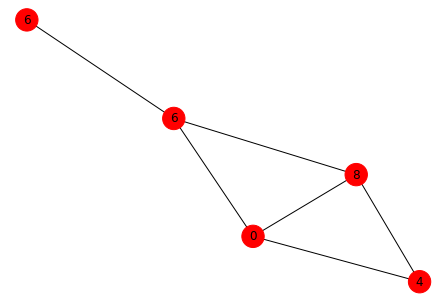

In [6]:
s_labels = [random.randint(0, 10) for i in range(num_node_s)]
s_edges = [pair for pair in combinations(list(range(num_node_s)), 2) if random.random() <= connect_prob_s]
# print(s_labels, s_edges)

plot_graph(s_labels, s_edges, [1 for i in range(len(s_labels))])

train = generate_dataset(s_labels, s_edges)
test = generate_dataset(s_labels, s_edges)

In [7]:
model = GNN2009(num_node, num_class, label_dim, stat_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

for epoch in range(1, num_epoch + 1):
    model.train()
    optimizer.zero_grad()
    
    out = model(train['label_matrix'], train['node_n'], train['node_u'], train['degree_n'])
    loss = F.nll_loss(out, train['targets'])
    _, pred = out.max(dim=1)

    correct = float(pred.eq(train['targets']).sum().item())
    acc = correct / num_node
    if epoch % 50 == 0:
        print(f'epoch {epoch}\t acc: {acc}')

    loss.backward()
    optimizer.step()

model.eval() 
out = model(test['label_matrix'], test['node_n'], test['node_u'], test['degree_n'])
_, pred = out.max(dim=1)

correct = float(pred.eq(test['targets']).sum().item())
acc = correct / num_node
print(f'test acc: {acc}')

epoch 50	 acc: 0.871
epoch 100	 acc: 0.9255
epoch 150	 acc: 0.9425
epoch 200	 acc: 0.9455
epoch 250	 acc: 0.902
epoch 300	 acc: 0.9485
epoch 350	 acc: 0.9505
epoch 400	 acc: 0.953
epoch 450	 acc: 0.955
epoch 500	 acc: 0.9575
epoch 550	 acc: 0.9575
epoch 600	 acc: 0.943
epoch 650	 acc: 0.959
epoch 700	 acc: 0.958
epoch 750	 acc: 0.9575
epoch 800	 acc: 0.9585
epoch 850	 acc: 0.9575
epoch 900	 acc: 0.955
epoch 950	 acc: 0.961
epoch 1000	 acc: 0.962
test acc: 0.946


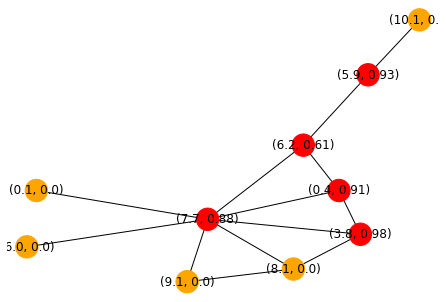

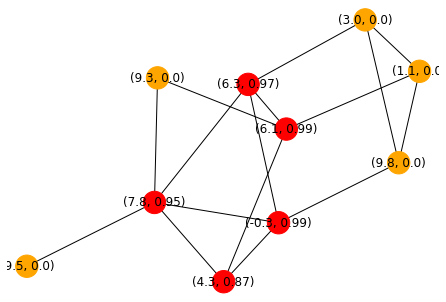

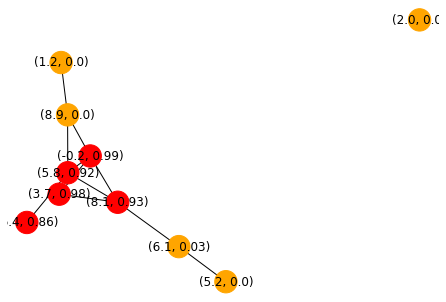

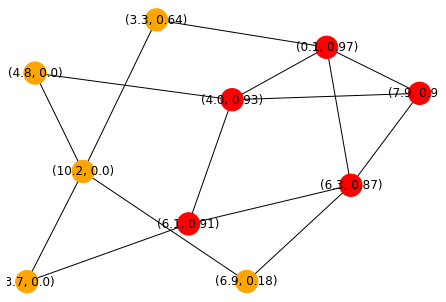

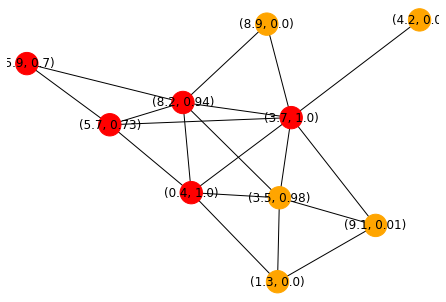

In [26]:
for k in range(5):
    plot_kth_graph(
        k, 
        [(round(l, 1), round(o, 2)) for l, o in zip(test['labels'], np.exp(out.detach().numpy())[:, 1])],
        test['edges'],
        test['targets'].tolist(),
        test['graph_index']
    )